In [ ]:
# pip install wordcloud
# pip install textblob

import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from textblob import TextBlob
from textblob import Word
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
data = pd.read_csv('Suicide_Detection.csv')
data.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232074 entries, 0 to 232073
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  232074 non-null  int64 
 1   text        232074 non-null  object
 2   class       232074 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.3+ MB


In [ ]:
data.groupby('class').size().reset_index(name='counts')

,class,counts
0,non-suicide,116037
1,suicide,116037


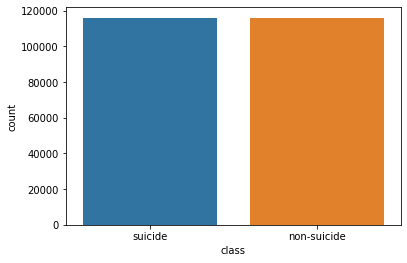

In [ ]:
sns.countplot(x=data['class'])

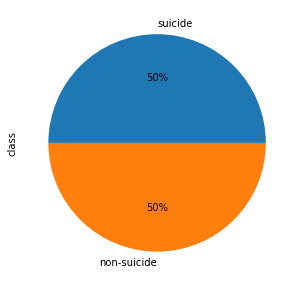

In [ ]:
data['class'].value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(5,5))

In [ ]:
data.duplicated().sum()

0

In [ ]:
data= data.drop_duplicates()

#  Data Preprocessing

In [ ]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Removing the noisy text
def remove_noise(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on text column
data['cleaned']=data['text'].apply(remove_noise)

In [ ]:
data

,Unnamed: 0,text,class,cleaned
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,Ex Wife Threatening SuicideRecently I left my ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,Am I weird I don't get affected by compliments...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,Finally 2020 is almost over... So I can never ...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"I’m so lostHello, my name is Adam (16) and I’v..."
...,...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide,If you don't like rock then your not going to ...
232070,348106,You how you can tell i have so many friends an...,non-suicide,You how you can tell i have so many friends an...
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably tastes like salty tea😏💦‼️ can som...
232072,348108,The usual stuff you find hereI'm not posting t...,suicide,The usual stuff you find hereI'm not posting t...


In [ ]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

def clean_text(text):
    text = text.lower()
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())
    return text

data['cleaned']=data['cleaned'].apply(clean_text)

In [ ]:
data

,Unnamed: 0,text,class,cleaned
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i do not get affected by compliment...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 is almost over . . . so i can nev...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,"i’m so losthello , my name is adam (16) and i’..."
...,...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide,if you do not like rock then your not going to...
232070,348106,You how you can tell i have so many friends an...,non-suicide,you how you can tell i have so many friends an...
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably tastes like salty tea😏💦‼️ can som...
232072,348108,The usual stuff you find hereI'm not posting t...,suicide,the usual stuff you find herei am not posting ...


In [ ]:
#Define function for removing special characters
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_special_characters)

In [ ]:
data

,Unnamed: 0,text,class,cleaned
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently i left my ...
1,3,Am I weird I don't get affected by compliments...,non-suicide,am i weird i do not get affected by compliment...
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,finally 2020 is almost over so i can never ...
3,8,i need helpjust help me im crying so hard,suicide,i need helpjust help me im crying so hard
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,im so losthello my name is adam 16 and ive be...
...,...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide,if you do not like rock then your not going to...
232070,348106,You how you can tell i have so many friends an...,non-suicide,you how you can tell i have so many friends an...
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probably tastes like salty tea can someone...
232072,348108,The usual stuff you find hereI'm not posting t...,suicide,the usual stuff you find herei am not posting ...


In [ ]:
#Stemming the text
def simple_stemmer(text):
    ps=nltk.porter.PorterStemmer()
    text= ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(simple_stemmer)

In [ ]:
#set stopwords to english

nltk.download('stopwords')
#Tokenization of text
tokenizer=ToktokTokenizer()
#Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

stop=set(stopwords.words('english'))
print(stop)

#removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

#Apply function on cleaned column
data['cleaned']=data['cleaned'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'now', "hadn't", 'my', 'does', 'same', 'ours', 'those', "aren't", 'm', 'be', "you're", 'so', 'myself', 'haven', 'll', 'below', 'hasn', 'when', 'other', "haven't", 'as', 'have', 'doesn', 'being', 'down', 'where', 'the', 'for', 'any', "mustn't", "isn't", 'hers', 'few', 'has', 'by', 'its', 'but', 'theirs', 'their', 'had', 'your', 'a', 'some', "hasn't", 'this', 'at', 'nor', "it's", 're', 'than', 'me', 'couldn', 'off', 'an', 'because', 'while', "wasn't", 'are', 'through', 'on', "couldn't", 'he', 'am', 'here', "you'd", 'or', "needn't", 'wouldn', 'after', 'that', 'into', 'itself', 'him', 'who', 'isn', 'own', 'yourself', 'themselves', 'what', "didn't", 'from', 'up', 'didn', 'further', 'too', 'wasn', 'weren', 'before', "that'll", 'we', 'y', 'them', 'yours', 'ain', 'there', 'ma', 'shouldn', 'whom', "weren't", 'against', "won't", 'above', 'hadn', 'each', 'was', 'with', 'to', 'all', 'over', 'do', 'of', 'she', 'in', "mightn't", 'mightn', 'our', "wouldn't", 'did', 'been', 'only', 'doing', 'were', '

In [ ]:
# Remove the Text with least words
data['length'] = data['cleaned'].apply(lambda x:len(x.split()))
dataset = data.loc[data.length>0]
dataset = dataset.reset_index(drop = True)
print("After Cleaning:","\nRemoved {} Small Text".format(len(data)-len(dataset)),
      "\nTotal Text:",len(dataset))

After Cleaning: 
Removed 69 Small Text 
Total Text: 232005


In [ ]:
data

,Unnamed: 0,text,class,cleaned,length
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threaten suiciderec left wife good bec...,67
1,3,Am I weird I don't get affected by compliments...,non-suicide,weird get affect compliment come someon know i...,13
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,final 2020 almost never hear 2020 ha bad year ...,14
3,8,i need helpjust help me im crying so hard,suicide,need helpjust help im cri hard,6
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,im losthello name adam 16 ive struggl year im ...,243
...,...,...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide,like rock go get anyth thi go httpsmusictast s...,10
232070,348106,You how you can tell i have so many friends an...,non-suicide,tell mani friend lone everyth depriv prebought...,14
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide,pee probabl tast like salti tea someon drank p...,12
232072,348108,The usual stuff you find hereI'm not posting t...,suicide,usual stuff find herei post thi sympathi piti ...,160


In [ ]:
dataset.groupby('class').size().reset_index(name='counts')

,class,counts
0,non-suicide,115978
1,suicide,116027


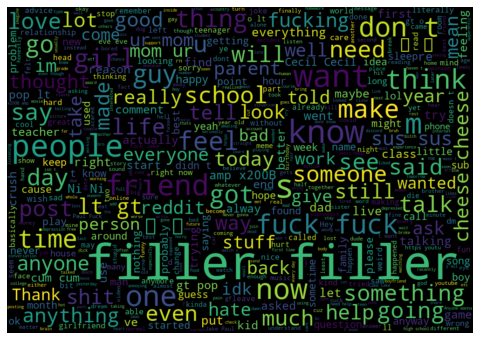

In [ ]:
# Plot the positive Word Cloud
pos_df = dataset[dataset['class'] == 'non-suicide']
positive_text = ' '.join([comnt for comnt in pos_df['text']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
positive_words=WC.generate(positive_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(positive_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

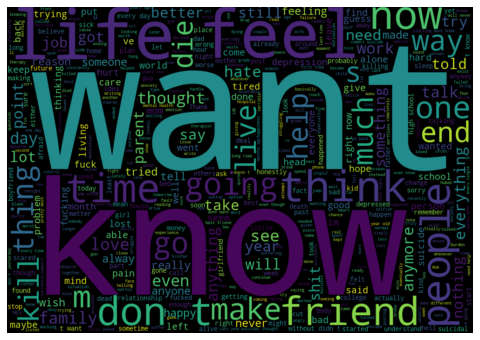

In [ ]:
# Plot the negative Word Cloud
neg_df = dataset[dataset['class'] == 'suicide']
negative_text = ' '.join([comnt for comnt in neg_df['text']])

WC=WordCloud(width=1000,height=700,max_words=500,min_font_size=5)
negative_words=WC.generate(negative_text)

fig = plt.figure(1, figsize=(10, 6))
plt.imshow(negative_words, interpolation = "bilinear")
plt.axis('off')
plt.show()

# Feature Extraction

In [ ]:
#Label Encoding Function
def label_encoding(label,bool):

    le = LabelEncoder()
    le.fit(label)
    encoded_labels = le.transform(label)
    labels = np.array(encoded_labels)
    class_names =le.classes_ 
    if bool == True:
        print("\n\t\t\t===== Label Encoding =====","\nClass Names:-->",le.classes_)
        for i in sample_data:
            print(label[i],' ', encoded_labels[i],'\n')

    return labels

In [ ]:
#Dataset Splitting Function
def dataset_split(feature_space,label):

    X_train,X_test,y_train,y_test = train_test_split(feature_space,label, test_size = 0.2,random_state =42,stratify=label)
    print("Feature Size :======>",X_train.shape[1])
    print("\nDataset Distribution:\n")
    print("\tSet Name","\t\tSize")
    print("\t========\t\t======")

    print("\tFull\t\t\t",feature_space.shape[0],
        "\n\tTraining\t\t",X_train.shape[0],
        "\n\tTest\t\t\t",X_test.shape[0])
  
    return X_train,X_test,y_train,y_test

In [ ]:
#TFIDF to convert text documents to matrix of features
def calc_gram_tfidf(text,gram):

    tfidf = TfidfVectorizer(ngram_range=gram,use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Unigram Tf-idf value calculation
def calc_unigram_tfidf(text):
    tfidf = TfidfVectorizer(use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Bi-gram Tf-idf value calculation
def calc_bigram_tfidf(text):
    tfidf = TfidfVectorizer(ngram_range=(1,2),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

#Tri-gram Tf-idf value calculation
def calc_trigram_tfidf(text):
    tfidf = TfidfVectorizer(ngram_range=(1,3),use_idf=True,tokenizer=lambda x: x.split()) 
    X = tfidf.fit_transform(text)
    
    return tfidf,X

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,f1_score

In [ ]:
def model_defination():
    
    lr_model = LogisticRegression(random_state = 123, max_iter = 10000)
    mnb_model = MultinomialNB(alpha=0.431)
    knn_model = KNeighborsClassifier(n_neighbors=100, metric = 'minkowski', algorithm = 'ball_tree', n_jobs = 10)
    sgd_model = SGDClassifier(loss ='log',penalty='l2', max_iter=5)
    xgb_model = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
    
    model_names = ['Logistic Regression','Naive Bayes','KNN','SGD','XGB']
    ml_models = [lr_model,mnb_model,knn_model,sgd_model,xgb_model]
    
    return ml_models,model_names

In [ ]:
def model_performace(model,X_train,X_test,y_train,y_test):
    
    my_dict = {}
    model.fit(X_train,y_train)
    pred_y = model.predict(X_test)
    my_dict['Accuracy'] = round(accuracy_score(y_test, pred_y),4)*100 
    my_dict['Precision'] = round(precision_score(y_test, pred_y,average='micro'),4)*100 
    my_dict['Recall'] = round(recall_score(y_test, pred_y,average='micro'),4)*100 
    my_dict['F1 Score'] = round(f1_score(y_test, pred_y,average='micro'),4)*100 
    
    return my_dict  

In [ ]:
def performance_table(performance_dict):

    acc_list = []
    pr_list = []
    re_list = []
    f1_list = []
    for i in performance_dict.keys():
        acc_list.append(performance_dict[i]['Accuracy'])
        pr_list.append(performance_dict[i]['Precision'])
        re_list.append(performance_dict[i]['Recall'])
        f1_list.append(performance_dict[i]['F1 Score'])

    performance_df = pd.DataFrame({'Accuracy':acc_list,'Precision':pr_list,
                                   'Recall':re_list,'F1 Score':f1_list},
                                  index =['LR','MNB','KNN','SGD','XGB'])
    performance_df.style.highlight_max(color = 'lightgreen', axis = 0)
    return performance_df

In [ ]:
path = "./json/"

In [ ]:
## save the performance of the model for each gram feature 
gram_names = ['Unigram','Bigram','Trigram']
ngrams = [(1,1),(1,2),(1,3)]
for i,gram in enumerate(ngrams):
    tfidf,feature = calc_gram_tfidf(dataset['cleaned'],gram)
    labels = label_encoding(dataset['class'],False)
    X_train,X_test,y_train,y_test = dataset_split(feature,labels) 
    ml_models,model_names = model_defination()
    
    accuracy = {f'{model_names[j]}':model_performace(model,X_train,X_test,y_train,y_test) for j,model in enumerate(ml_models)}

    with open(path+f'ML_{gram_names[i]}.json', 'w') as f:
          json.dump(accuracy, f)

Feature Size :======> 159980

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 232005 
	Training		 185604 
	Test			 46401
Feature Size :======> 3257404

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 232005 
	Training		 185604 
	Test			 46401
Feature Size :======> 13839074

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 232005 
	Training		 185604 
	Test			 46401


In [ ]:
accuracy1 = json.load(open('./json/ML_Unigram.json'))
table1 = performance_table(accuracy1)
table1

,Accuracy,Precision,Recall,F1 Score
LR,93.45,93.45,93.45,93.45
MNB,89.83,89.83,89.83,89.83
KNN,89.33,89.33,89.33,89.33
SGD,91.39,91.39,91.39,91.39
XGB,88.46,88.46,88.46,88.46


In [ ]:
print(f"Highest Accuracy achieved by {table1.Accuracy.idxmax(axis = 0)} at = {max(table1.Accuracy)}")
print(f"Highest F1-Score achieved by {table1['F1 Score'].idxmax(axis = 0)} at = {max(table1['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table1['Precision'].idxmax(axis = 0)} at = {max(table1['Precision'] )}")
print(f"Highest Recall Score achieved by {table1['Recall'].idxmax(axis = 0)} at = {max(table1['Recall'] )}")

Highest Accuracy achieved by LR at = 93.45
Highest F1-Score achieved by LR at = 93.45
Highest Precision Score achieved by LR at = 93.45
Highest Recall Score achieved by LR at = 93.45


In [ ]:
accuracy2 = json.load(open('./json/ML_Bigram.json'))
table2 = performance_table(accuracy2)
table2

,Accuracy,Precision,Recall,F1 Score
LR,93.37,93.37,93.37,93.37
MNB,85.97,85.97,85.97,85.97
KNN,89.52,89.52,89.52,89.52
SGD,90.06,90.06,90.06,90.06
XGB,88.47,88.47,88.47,88.47


In [ ]:
print(f"Highest Accuracy achieved by {table2.Accuracy.idxmax(axis = 0)} at = {max(table2.Accuracy)}")
print(f"Highest F1-Score achieved by {table2['F1 Score'].idxmax(axis = 0)} at = {max(table2['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table2['Precision'].idxmax(axis = 0)} at = {max(table2['Precision'] )}")
print(f"Highest Recall Score achieved by {table2['Recall'].idxmax(axis = 0)} at = {max(table2['Recall'] )}")

Highest Accuracy achieved by LR at = 93.37
Highest F1-Score achieved by LR at = 93.37
Highest Precision Score achieved by LR at = 93.37
Highest Recall Score achieved by LR at = 93.37


In [ ]:
accuracy3 = json.load(open('./json/ML_Trigram.json'))
table3 = performance_table(accuracy3)
table3

,Accuracy,Precision,Recall,F1 Score
LR,92.90,92.90,92.90,92.90
MNB,83.97,83.97,83.97,83.97
KNN,89.55,89.55,89.55,89.55
SGD,89.06,89.06,89.06,89.06
XGB,88.40,88.40,88.40,88.40


In [ ]:
print(f"Highest Accuracy achieved by {table3.Accuracy.idxmax(axis = 0)} at = {max(table3.Accuracy)}")
print(f"Highest F1-Score achieved by {table3['F1 Score'].idxmax(axis = 0)} at = {max(table3['F1 Score'] )}")
print(f"Highest Precision Score achieved by {table3['Precision'].idxmax(axis = 0)} at = {max(table3['Precision'] )}")
print(f"Highest Recall Score achieved by {table3['Recall'].idxmax(axis = 0)} at = {max(table3['Recall'] )}")

Highest Accuracy achieved by LR at = 92.9
Highest F1-Score achieved by LR at = 92.9
Highest Precision Score achieved by LR at = 92.9
Highest Recall Score achieved by LR at = 92.9


# Final Model

 - Selected feature: Unigram
 - Selected model: LR

In [ ]:
# calculate the Uni-gram Tf-idf feature
cv,feature_vector = calc_unigram_tfidf(dataset['cleaned'])

lables = label_encoding(dataset['class'],False)

X_train,X_test,y_train,y_test = dataset_split(feature_vector,lables)

Feature Size :======> 159980

Dataset Distribution:

	Set Name 		Size
	========		======
	Full			 232005 
	Training		 185604 
	Test			 46401


In [ ]:
# Train LR model and calculate the pred value
classifier1 = LogisticRegression(random_state = 123, max_iter = 10000)
classifier1.fit(X_train, y_train)
y_pred = classifier1.predict(X_test)

In [ ]:
# calculate train and test accuracy 
print(f"Train Accuracy is: {round(classifier1.score(X_train, y_train)*100,2)}%")
print(f"Test Accuracy is : {round(classifier1.score(X_test, y_test)*100,2)}%")

Train Accuracy is: 94.17%
Test Accuracy is : 93.45%


In [ ]:
# calculate classification report
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.94     23196
           1       0.95      0.92      0.93     23205

    accuracy                           0.93     46401
   macro avg       0.93      0.93      0.93     46401
weighted avg       0.93      0.93      0.93     46401



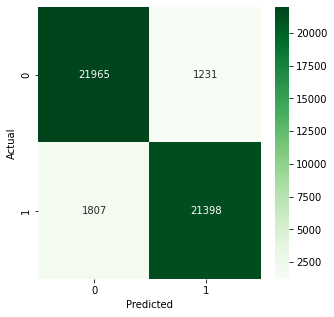

In [ ]:
# plot confusion matrix
conf_mat = confusion_matrix(y_test,y_pred)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d',cmap='Greens')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()